# **Capstone Project - Decent and Indecent Clothes Classification Model**

**Team ID** : C241-PS306

**Anggota** :

*   Muhammad Farhan Akmal (M012D4KY2187)
*   Gibran Ariq Natakusuma (M012D4KY2405)
*   Muthia Rasikha Zahra (M299D4KX1388)






## **Importing Required Libraries**

In [1]:
!pip install keras_preprocessing

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 686.4 kB/s eta 0:00:00


In [2]:
import tensorflow as tf
import pathlib
import matplotlib.pyplot as plt
import numpy as np
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications import MobileNetV2, InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Splitting Dataset**

In [4]:
# !pip install split-folders

In [5]:
# import splitfolders

# # Input folder containing 'decent' and 'indecent' subfolders
# input_folder = "/content/drive/MyDrive/Dataset_Bangkit/data"

# # Output folder where the split data will be stored
# output_folder = "/content/drive/MyDrive/Dataset_Bangkit/data_split2"

# # Split with a ratio of 80:20
# splitfolders.ratio(input_folder, output=output_folder, seed=1337, ratio=(0.8, 0.2), group_prefix=None)

## **Model Creation**

### **Set Paths**

In [6]:
# Define paths
train_dir = '/content/drive/MyDrive/Dataset_Bangkit/data_split/train'
val_dir = '/content/drive/MyDrive/Dataset_Bangkit/data_split/val'

### **Augmenting Data**

In [7]:
def train_val_generators(train_dir, val_dir):

    train_datagen = ImageDataGenerator(
        rescale=1.0/255.0,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        fill_mode='nearest'
    )

    validation_datagen = ImageDataGenerator(rescale=1.0/255.0)


    train_generator = train_datagen.flow_from_directory(
      train_dir,
      target_size=(256, 256),
      batch_size=32,
      class_mode='binary'
    )

    validation_generator = validation_datagen.flow_from_directory(
        val_dir,
        target_size=(256, 256),
        batch_size=32,
        class_mode='binary'
    )

    return train_generator, validation_generator

In [8]:
train_generator, validation_generator = train_val_generators(train_dir, val_dir)

Found 802 images belonging to 2 classes.
Found 344 images belonging to 2 classes.


(32, 256, 256, 3)


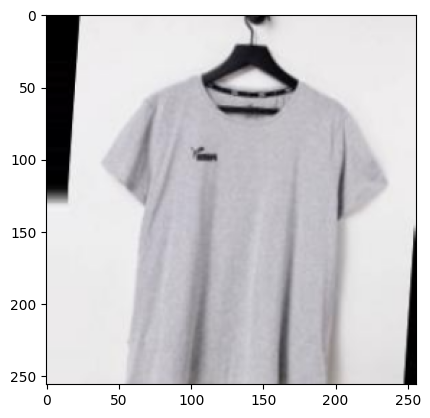

(32, 256, 256, 3)


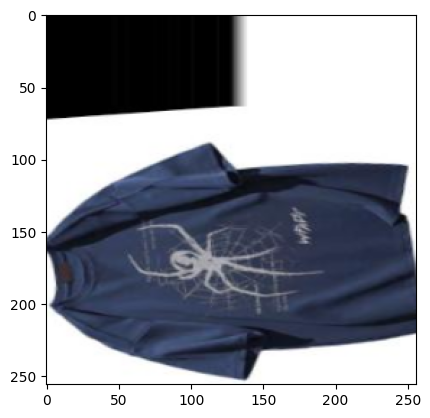

(32, 256, 256, 3)


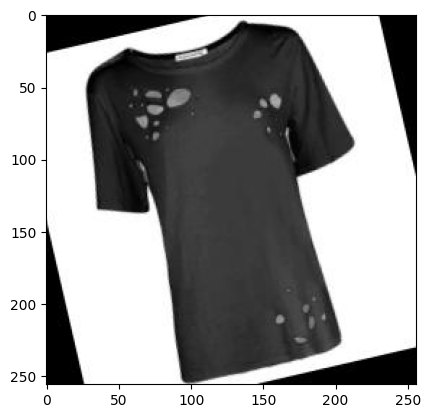

(32, 256, 256, 3)


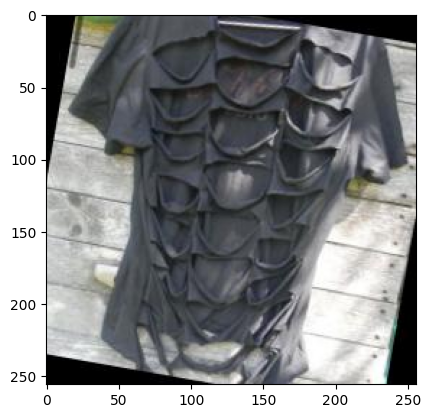

In [9]:
for _ in range(2):
    img, label = train_generator.next()
    plt.imshow(np.squeeze(img[0]))
    print(img.shape)
    plt.show()

for _ in range(2):
    img, label = validation_generator.next()
    plt.imshow(np.squeeze(img[0]))
    print(img.shape)
    plt.show()

In [10]:
# Get the class details
class_details = validation_generator.class_indices

# Print the class details
for class_name, class_index in class_details.items():
    print("Class:", class_name)
    print("Index:", class_index)


Class: decent
Index: 0
Class: indecent
Index: 1


### **Creating the Base Model**

In [11]:
def create_model(base_model):
    base_model.trainable = False
    model = Sequential([
        base_model,
        Dropout(0.5),
        GlobalAveragePooling2D(),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

### **Using Callbacks**

In [12]:
# Add custom callback to stop after accuracy > 99%
class EarlyStoppingByAccuracy(Callback):
    def on_epoch_end(self, epoch, logs=None):
        accuracy = logs.get("accuracy")
        if accuracy is not None and accuracy > 0.99:
            print(f"\nAccuracy reached {accuracy * 100:.2f}%, stopping training.")
            self.model.stop_training = True

In [13]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='min'),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, mode='min'),
    EarlyStoppingByAccuracy()
]

### **Using Pretrained MobileNetV2 Model**

In [14]:
base_model_mobilenet = MobileNetV2(input_shape=(256, 256, 3),
                                   include_top=False,
                                   weights='imagenet')
for layer in base_model_mobilenet.layers:
  layer.trainable = False
base_model_mobilenet.summary()
model_mobilenet = create_model(base_model_mobilenet)
model_mobilenet.summary()

9406464/9406464 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 128, 128, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 128, 128, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReL

In [15]:
history_mobilenet = model_mobilenet.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=50,
    callbacks=callbacks
)

Epoch 1/50
25/25 [==============================] - 217s 9s/step - loss: 0.6975 - accuracy: 0.5714 - val_loss: 0.6731 - val_accuracy: 0.6094 - lr: 1.0000e-04
Epoch 2/50
25/25 [==============================] - 73s 3s/step - loss: 0.6458 - accuracy: 0.6156 - val_loss: 0.6248 - val_accuracy: 0.6719 - lr: 1.0000e-04
Epoch 3/50
25/25 [==============================] - 76s 3s/step - loss: 0.6030 - accuracy: 0.6701 - val_loss: 0.5909 - val_accuracy: 0.7000 - lr: 1.0000e-04
Epoch 4/50
25/25 [==============================] - 73s 3s/step - loss: 0.5758 - accuracy: 0.7169 - val_loss: 0.5530 - val_accuracy: 0.7500 - lr: 1.0000e-04
Epoch 5/50
25/25 [==============================] - 84s 3s/step - loss: 0.5481 - accuracy: 0.7429 - val_loss: 0.5355 - val_accuracy: 0.7594 - lr: 1.0000e-04
Epoch 6/50
25/25 [==============================] - 77s 3s/step - loss: 0.5215 - accuracy: 0.7727 - val_loss: 0.5077 - val_accuracy: 0.7937 - lr: 1.0000e-04
Epoch 7/50
25/25 [==============================] - 72s 3

In [16]:
loss_mobilenet, accuracy_mobilenet = model_mobilenet.evaluate(validation_generator, steps=validation_generator.samples // validation_generator.batch_size)
print(f"MobileNetV2 Validation Accuracy: {accuracy_mobilenet * 100:.2f}%")

10/10 [==============================] - 17s 2s/step - loss: 0.2248 - accuracy: 0.9312
MobileNetV2 Validation Accuracy: 93.12%


### **Using Pretrained InceptionV3 Model**

In [17]:
base_model_inception = InceptionV3(input_shape=(256, 256, 3),
                                   include_top=False,
                                   weights='imagenet')
for layer in base_model_inception.layers:
  layer.trainable = False
base_model_inception.summary()
model_inception = create_model(base_model_inception)

87910968/87910968 [==============================] - 1s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 127, 127, 32)         864       ['input_2[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 127, 127, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activatio

In [18]:
history_inception = model_inception.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=50,
    callbacks=callbacks
)

Epoch 1/50
25/25 [==============================] - 215s 8s/step - loss: 0.6990 - accuracy: 0.5273 - val_loss: 0.6955 - val_accuracy: 0.5562 - lr: 1.0000e-04
Epoch 2/50
25/25 [==============================] - 172s 7s/step - loss: 0.6668 - accuracy: 0.5753 - val_loss: 0.6489 - val_accuracy: 0.6469 - lr: 1.0000e-04
Epoch 3/50
25/25 [==============================] - 206s 8s/step - loss: 0.6186 - accuracy: 0.6519 - val_loss: 0.6127 - val_accuracy: 0.7000 - lr: 1.0000e-04
Epoch 4/50
25/25 [==============================] - 207s 8s/step - loss: 0.6056 - accuracy: 0.6662 - val_loss: 0.5806 - val_accuracy: 0.7281 - lr: 1.0000e-04
Epoch 5/50
25/25 [==============================] - 213s 9s/step - loss: 0.5636 - accuracy: 0.7442 - val_loss: 0.5573 - val_accuracy: 0.7500 - lr: 1.0000e-04
Epoch 6/50
25/25 [==============================] - 173s 7s/step - loss: 0.5446 - accuracy: 0.7610 - val_loss: 0.5367 - val_accuracy: 0.7781 - lr: 1.0000e-04
Epoch 7/50
25/25 [==============================] - 

In [19]:
loss_inception, accuracy_inception = model_inception.evaluate(validation_generator, steps=validation_generator.samples // validation_generator.batch_size)
print(f"InceptionV3 Validation Accuracy: {accuracy_inception * 100:.2f}%")

10/10 [==============================] - 48s 5s/step - loss: 0.2928 - accuracy: 0.8875
InceptionV3 Validation Accuracy: 88.75%


### **Comparing the Results**

MobileNetV2 Validation Accuracy: 93.12%
InceptionV3 Validation Accuracy: 88.75%


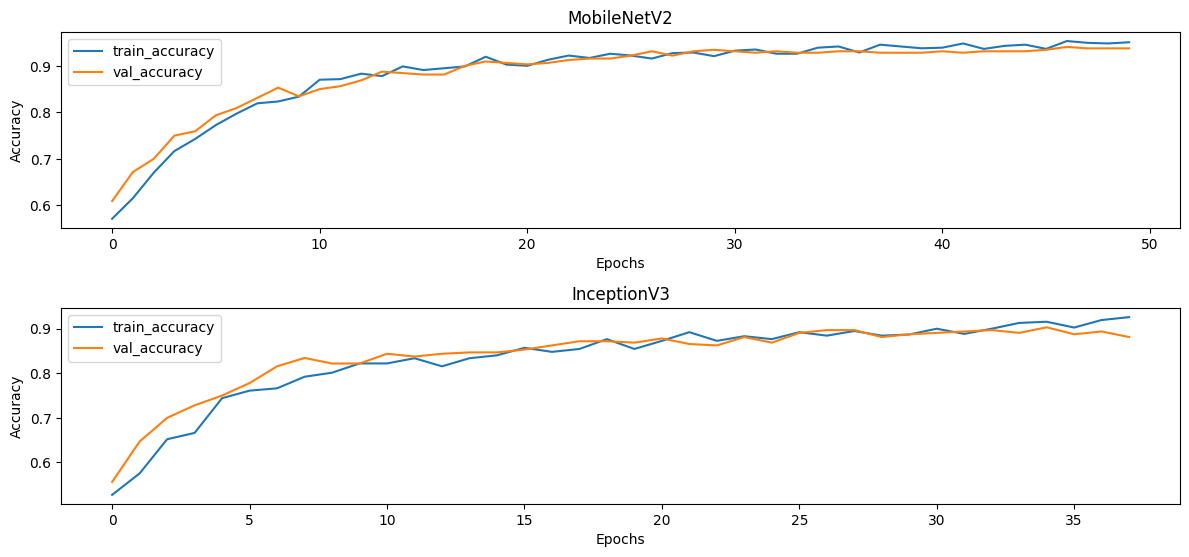

In [20]:
# Print out the validation accuracies
print(f"MobileNetV2 Validation Accuracy: {accuracy_mobilenet * 100:.2f}%")
print(f"InceptionV3 Validation Accuracy: {accuracy_inception * 100:.2f}%")

# Plot the training history
def plot_history(histories, titles):
    plt.figure(figsize=(12, 8))
    for i, history in enumerate(histories):
        plt.subplot(3, 1, i+1)
        plt.plot(history.history['accuracy'], label='train_accuracy')
        plt.plot(history.history['val_accuracy'], label='val_accuracy')
        plt.title(titles[i])
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
    plt.tight_layout()
    plt.show()

plot_history([history_mobilenet, history_inception],
             ['MobileNetV2', 'InceptionV3'])


## **Export Model**

### **Export Model as a .h5 Extension**

In [21]:
model_mobilenet.save('MobileNet.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### **Export Model as a .tflite Extension**

In [22]:
export_dir = '/content/drive/MyDrive/model'
tf.saved_model.save(model_mobilenet, export_dir)

# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

# Save the model
tflite_model_file = pathlib.Path('/content/drive/MyDrive/model/model_indecent_detection.tflite')
tflite_model_file.write_bytes(tflite_model)

8871352

### **Testing the Model**

In [23]:
# Load TFLite model and allocate tensors
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
input_shape = input_details[0]['shape']
input_data = np.array(np.random.random_sample(input_shape), dtype=np.float32)

# Point the data to be used for testing and run the interpreter
interpreter.set_tensor(input_details[0]['index'], input_data)
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

In [24]:
tflite_results

array([[0.71117246]], dtype=float32)